# Module 2 Summative Lab

***This is my Final Notebook for the Mod 2 Summative Lab.*** 

## The Goal  - Extract, Transform, and Load (ETL)

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)
* The team's win percentage on days where it was raining during games in the 2011 season.

***Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well-structured classes in your solution!***

## Plan of attach
1. Plan the plan
2. Query the SQL database
3. Calculate summary statistics
4. Get the weather data from the DarkSky API
5. Load the data into MongoDB
6. Refactor

Be sure to plan the inputs, outputs, and methods for each class before you begin coding!

In [12]:
# Import Libraries
import sqlite3
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
!pip install pymongo
import pymongo
import requests

In [ ]:
# I can only get pymongo to work with the Python3 kernal. NOT with learn-env.

## Query the Database

In [86]:
class Query_SQL():
    
    # Load connection and cursor
    conn = sqlite3.connect('database.sqlite')
    cur = conn.cursor()

    # Join some of the tables to get a datafrom with all the matches.
    cur.execute("""SELECT * 
               FROM Teams_in_Matches
               JOIN Unique_Teams
               USING(Unique_Team_ID)
               JOIN Matches
               USING(Match_ID)
               WHERE Season = 2011
               ORDER BY Match_ID DESC
               ;""")

    df = pd.DataFrame(cur.fetchall())
    df.columns = [x[0] for x in cur.description]

    conditions = [
        (df['TeamName'] == df['HomeTeam']) & (df['FTR'] == 'H'),
        (df['TeamName'] == df['AwayTeam']) & (df['FTR'] == 'A')]
    choices = [1, 1]

    df['Winner'] = np.select(conditions, choices, default=0)

    # Create new df with just the Teams
    cur.execute("""SELECT TeamName
               FROM Teams_in_Matches
               JOIN Unique_Teams
               USING(Unique_Team_ID)
               JOIN Matches
               USING(Match_ID)
               WHERE Season = 2011
               GROUP BY TeamName
               ORDER BY TeamName
               ;""")
    df_wins = pd.DataFrame(cur.fetchall())
    df_wins.columns = [x[0] for x in cur.description]

    # Create a list using groupby to find the total wins
    Total_Wins = list(df.groupby('TeamName')['Winner'].sum())
    print(len(Total_Wins))

    # Bayer Munich is in there twice, so delete the bad one.
    #del Total_Wins[4]

    # Join list as a new column in df with just teams
    df_wins['Total_Wins'] = Total_Wins

df_wins.head()

56


,TeamName,Total_Wins
0,Aachen,6
1,Arsenal,21
2,Aston Villa,7
3,Augsburg,8
4,Bayern Munich,23


## DarkSky API Weather

In [13]:
#class WeatherGetter():
    
# Create a blank page with my secret key
def get_keys(path):
    with open(path) as f:
        return json.load(f)

key = get_keys("/Users/whipxach/.secret/dark_sky_api.json")

api_key = key['api_key']

# API Request with working format and a 'single' UNIX date
url_params = {
                'api_key': api_key, 
                "latitude":'52.520008',
                "longitude":'13.404954',
                "time":'1294808400'
             }


response = requests.get('https://api.darksky.net/forecast/{api_key}/{latitude},{longitude},{time}?exclude=hourly,flags'.format(**url_params))
print(response)
print(response.text[0:1000])

<Response [200]>
{"latitude":52.520008,"longitude":13.404954,"timezone":"Europe/Berlin","currently":{"time":1294808400,"summary":"Drizzle","icon":"rain","precipIntensity":0.0099,"precipProbability":1,"precipType":"rain","temperature":39.25,"apparentTemperature":31.54,"dewPoint":37.4,"humidity":0.93,"windSpeed":13,"windGust":13,"windBearing":251,"cloudCover":0.89,"uvIndex":0,"visibility":3.73},"daily":{"data":[{"time":1294786800,"summary":"Light rain in the morning and overnight.","icon":"rain","sunriseTime":1294816440,"sunsetTime":1294845480,"moonPhase":0.26,"precipIntensity":0.001,"precipIntensityMax":0.01,"precipIntensityMaxTime":1294808820,"precipProbability":1,"precipType":"rain","temperatureHigh":41.65,"temperatureHighTime":1294834860,"temperatureLow":36.83,"temperatureLowTime":1294874640,"apparentTemperatureHigh":33.17,"apparentTemperatureHighTime":1294837140,"apparentTemperatureLow":30.93,"apparentTemperatureLowTime":1294873380,"dewPoint":33.38,"humidity":0.8,"windSpeed":11.81,"

## Histogram

        TeamName  HomeGoals  AwayGoals  Games_Played
0         Aachen         38         39            34
1        Arsenal         71         52            38
2    Aston Villa         48         42            38
3       Augsburg         50         35            34
4  Bayern Munich         65         34            34


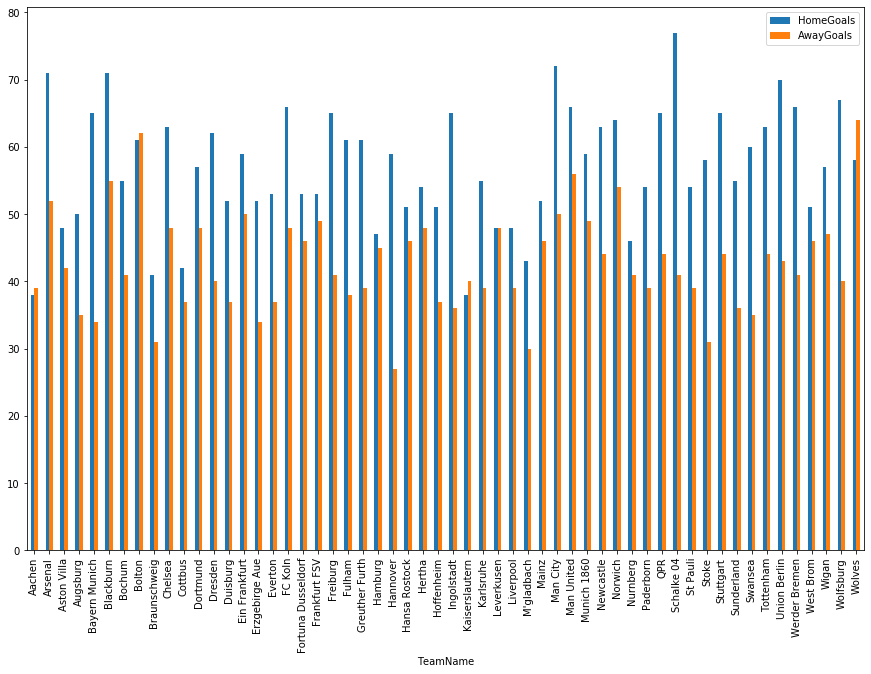

In [98]:
class Bar_Plot_Maker():
    # Load the data
    conn = sqlite3.connect('database.sqlite')
    cur = conn.cursor()

    # Get the data for the histogram
    cur.execute("""SELECT TeamName, SUM(FTHG) AS HomeGoals, SUM(FTAG) AS AwayGoals, COUNT(FTR) AS Games_Played
               FROM Unique_Teams
               JOIN Teams_in_Matches
               USING(Unique_Team_ID)
               JOIN Matches
               USING(Match_ID)
               WHERE Season = 2011
               GROUP BY TeamName
               ORDER BY TeamName
               ;""")
    df = pd.DataFrame(cur.fetchall())
    df.columns = [x[0] for x in cur.description]
    print(df.head())

    # Make a bar graph for each team and their 'home' vs. 'away' goals
    df.plot.bar(x ='TeamName', y=['HomeGoals', 'AwayGoals'],figsize=(15, 10))


## Another Bar Graph

     TeamName  Total_Goals
0   Blackburn          126
1     Arsenal          123
2      Bolton          123
3    Man City          122
4  Man United          122


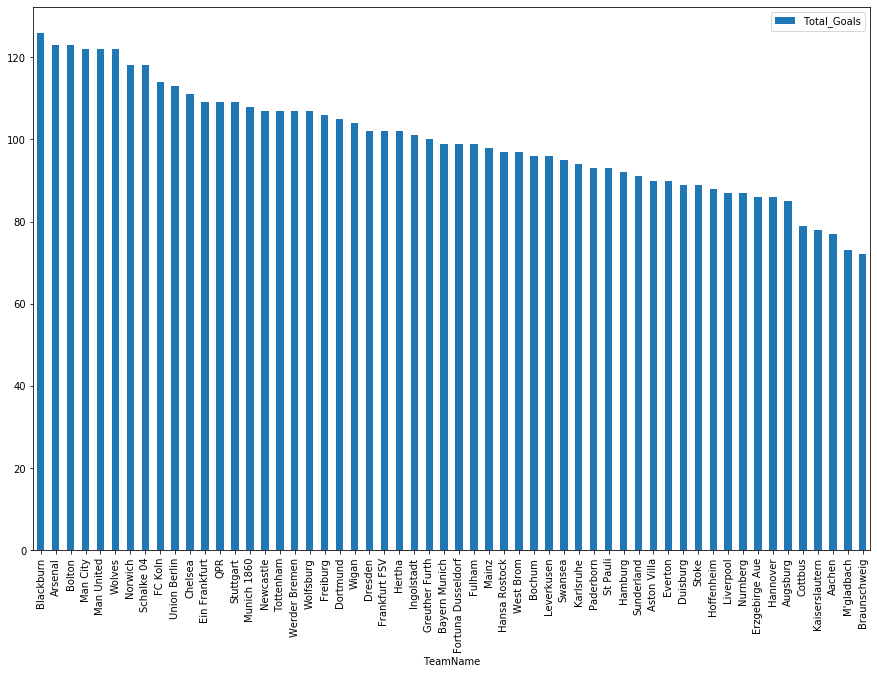

In [70]:
# Total team wins histogram
cur.execute("""SELECT TeamName, SUM(FTHG) + SUM(FTAG) AS Total_Goals
               FROM Unique_Teams
               JOIN Teams_in_Matches
               USING(Unique_Team_ID)
               JOIN Matches
               USING(Match_ID)
               WHERE Season = 2011
               GROUP BY TeamName
               ORDER BY Total_Goals DESC
               ;""")
df2 = pd.DataFrame(cur.fetchall())
df2.columns = [x[0] for x in cur.description]
print(df2.head())

#Make Bar Plot for each team and their total goals
df2.plot.bar(x ='TeamName', y='Total_Goals',figsize=(15, 10))

## Calculate summary statistics

In [89]:
class Summary_stats():
    
    # Load connection and cursor
    conn = sqlite3.connect('database.sqlite')
    cur = conn.cursor()

    # Get Total goals for each team from SQL
    cur.execute("""SELECT TeamName, SUM(FTHG) + SUM(FTAG) AS Total_Goals
               FROM Unique_Teams
               JOIN Teams_in_Matches
               USING(Unique_Team_ID)
               JOIN Matches
               USING(Match_ID)
               WHERE Season = 2011
               GROUP BY TeamName
               ORDER BY TeamName
               ;""")
    df_goals = pd.DataFrame(cur.fetchall())
    df_goals.columns = [x[0] for x in cur.description]
df_goals.head()

,TeamName,Total_Goals
0,Aachen,77
1,Arsenal,123
2,Aston Villa,90
3,Augsburg,85
4,Bayern Munich,99


In [95]:
# Join the total goals and the total wins dataframes
final_df = pd.merge(df_wins, df_goals)
final_df.head()

,TeamName,Total_Wins,Total_Goals
0,Aachen,6,77
1,Arsenal,21,123
2,Aston Villa,7,90
3,Augsburg,8,85
4,Bayern Munich,23,99


## Load the data into MongoDB

In [103]:
class MongoHandler():
    
    #Set up the client
    myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
    #Create an empty file
    soccer_db = myclient['soccer_db']
    #Allow for data to be entered
    soccer_collection = soccer_db['soccer_collection']
    #Insert the data
    soccer_collection.insert_many(final_df.to_dict('records'))
    #View the data in MongoDB
    team_query = soccer_collection.find({})
    for x in team_query:
        print(x)

{'_id': ObjectId('5dd17a50f03972ec07bd0d82'), 'TeamName': 'Blackburn', 'Total_Goals': 126, 'Total_Wins': 38}
{'_id': ObjectId('5dd17a50f03972ec07bd0d83'), 'TeamName': 'Arsenal', 'Total_Goals': 123, 'Total_Wins': 38}
{'_id': ObjectId('5dd17a50f03972ec07bd0d84'), 'TeamName': 'Bolton', 'Total_Goals': 123, 'Total_Wins': 38}
{'_id': ObjectId('5dd17a50f03972ec07bd0d85'), 'TeamName': 'Man City', 'Total_Goals': 122, 'Total_Wins': 38}
{'_id': ObjectId('5dd17a50f03972ec07bd0d86'), 'TeamName': 'Man United', 'Total_Goals': 122, 'Total_Wins': 38}
{'_id': ObjectId('5dd17a50f03972ec07bd0d87'), 'TeamName': 'Wolves', 'Total_Goals': 122, 'Total_Wins': 38}
{'_id': ObjectId('5dd17a50f03972ec07bd0d88'), 'TeamName': 'Norwich', 'Total_Goals': 118, 'Total_Wins': 38}
{'_id': ObjectId('5dd17a50f03972ec07bd0d89'), 'TeamName': 'Schalke 04', 'Total_Goals': 118, 'Total_Wins': 34}
{'_id': ObjectId('5dd17a50f03972ec07bd0d8a'), 'TeamName': 'FC Koln', 'Total_Goals': 114, 'Total_Wins': 34}
{'_id': ObjectId('5dd17a50f039

## Refactoring

I spent some time refactoring, but I am still confused on how the 'classes' work and I can't really figure out the Object-Oriented Programming (how it should look and run). 

### Issues

I still can't figure out how to get ALL the date features in the date column into UNIX code or a format that the DarkSky API would work.

I also need to learn how to create a loop to pass in each of the date features in order to get a response for each game.

Furthermore, DarkSky was confusing and I couldn't figure out how to get the "rain" information, just the temperature and stuff - therefore I didn't join the third column of data about how rain afffected performance.